In [4]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit


#import radiometric functions 
sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df

#import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import create_NUC_df, collapse_df,compile_NUC_matrix_input,calc_NUC_coef

In [5]:
#will create a df and print the names of the keys in the original hdf5 file

#choose filepath to desired data
path = '/Volumes/KESU/mar02/'

df = create_NUC_df(path,'50C.h5')

In [6]:
#select ROI
ymin2 = 105; ymax2 = 130;
ymin1 = 130; ymax1 = 155;

#temperatures contained in NUC file
temps = [35,36,37,38,39,41,42,43,44,45,46,47,48,49,51,52,53,54,55,56,57,58,59,61,62,63,64,65,66,67,68,69,71,75]

In [7]:
# preallocate array
bbtemps1 = [];bbtemps2 = []; temps1 =[];temps2 = []; images1 =[]; images2 = []

#accumulate all data from hdf5 files
for t in temps:
       #choose filepath to desired data",
        cal_file = str(t)+'C.h5'
        df = create_NUC_df(path,cal_file)
        t1,i1,t2,i2 = collapse_df(df)
        bbtemps1.extend(np.ones(len(t1))*t)
        bbtemps2.extend(np.ones(len(t2))*t)
        temps1.extend(t1)
        temps2.extend(t2)
        images1.extend(i1)
        images2.extend(i2)

In [8]:
#create dictionaries of loaded data for each camera
data1= {'bbtemp': bbtemps1, 'temps1': temps1,'images1':list(images1)}
data2= {'bbtemp': bbtemps2, 'temps1': temps2,'images1':list(images2)}

In [9]:
#convert dictionaries to dataframe objects
cam1 = pd.DataFrame.from_dict(data1, orient='index')
cam2 = pd.DataFrame.from_dict(data2, orient='index')


In [10]:
def compile_NUC_matrix_input(df):
    '''
    this function will prepare NUC averaged data for NUC_coef()
    df should be averages df from collapse df
    returns and determines reference  temperature 
    returns arrays T adn r for NUC_coef()
    '''
    #find FPA temp with most instances, this is the reference temp
    T_ref = (df['temps1'].value_counts().index.tolist())[0]

    #find BB temps which have a FPA measurement at T_ref
    bbs = np.array(df.query('temps1=='+str(T_ref))['bbtemp'])

    #find unique temps that have more than one FPA temp
    Ts =np.array(df.bbtemp.value_counts().loc[lambda x: x>1].index)

    #find common list of BB temps with at least 2 members and T_ref
    ts = np.intersect1d(Ts,bbs)

    #make new df
    for i in range(len(ts)):
        dfs = df.loc[df['bbtemp'] == ts[i]]

        #select T-ref first, then other temp 
        T1 = np.array(dfs.loc[dfs['temps1'] == T_ref]['temps1']) [0]
        T2 = np.array(dfs.loc[dfs['temps1'] != T_ref]['temps1']) [0]
        r1 = np.array(dfs.loc[dfs['temps1'] == T_ref]['images1'])[0]
        r2 = np.array(dfs.loc[dfs['temps1'] != T_ref]['images1'])[0]
        tfpas     = [T1,T2]
        responses = [r1,r2]
        if i == 0:
            tFPAS = tfpas;
            rs = responses
        else:
            tFPAS = np.concatenate((tFPAS, tfpas) , axis=0)
            rs    = np.concatenate((rs, responses), axis=0)
        
    return(T_ref, tFPAS, rs)       

In [11]:
T_ref1, tFPAS1, rs1 = compile_NUC_matrix_input(cam1.T)
T_ref2, tFPAS2, rs2 = compile_NUC_matrix_input(cam2.T)

In [12]:
"Compute Camera 1 Coefficients"

m1 = np.zeros([256,320]); b1= np.zeros([256,320]);

for i in range(320):
        for j in range(256):
            m,b = calc_NUC_coef(tFPAS1,rs1,i,j)
            m1[j,i] = m
            b1[j,i] = b


In [13]:
"Compute Camera 2 Coefficients"

m2 = np.zeros([256,320]); b2= np.zeros([256,320]);

for i in range(320):
        for j in range(256):
            m,b = calc_NUC_coef(tFPAS2,rs2,i,j)
            m2[j,i] = m
            b2[j,i] = b


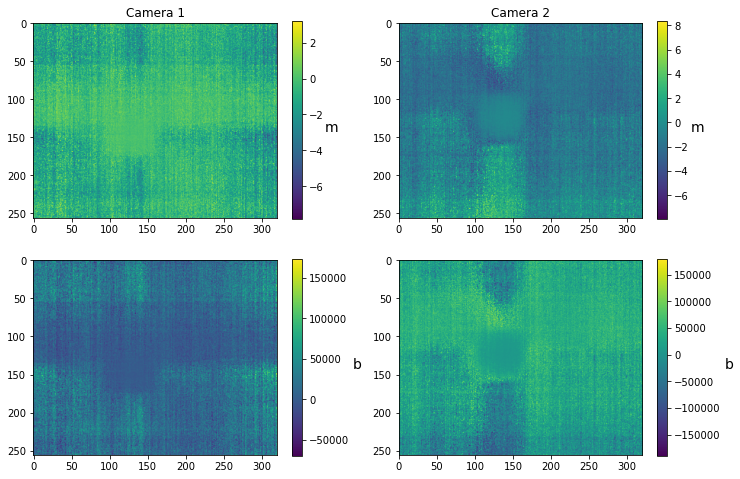

In [14]:
from matplotlib import colors, cm

fig, axs = plt.subplots(2, 2,figsize=(12, 8))
cm = ['viridis', 'viridis']
coefs = [[m1,m2],[b1,b2]]

cbartit = ["m","b"]
titles = ["Camera 1","Camera 2"]

for col in range(2):
    for row in range(2):
        ax = axs[row, col]
        #ax.axis('off')
        if row == 0:
            pcm = ax.imshow(coefs[row][col],cmap=cm[row])
        else:
            pcm = ax.imshow(coefs[row][col],cmap=cm[row])
        cbar = fig.colorbar(pcm, ax=ax)
        if row == 0:
            ax.title.set_text(titles[col])
            cbar.ax.set_ylabel('  m',rotation='horizontal',fontsize = 14)
        else:    
            cbar.ax.set_ylabel('  b',rotation='horizontal',fontsize = 14)
plt.show()


In [15]:
def rc(r,T,m,b,T_ref):
    ''''this is the NUC correction function'''
    return((r+b*(T_ref-T))/(1-m*(T_ref-T)))


'''fix wrapping error for temperatures '''
def correct_temps(df,key):
    for i in range(len(df[key])):
        if df[key][i] > 100:
            t1 = df[key][i]
            t2 =t1-6553.5
            df[key][i] = t2

In [17]:
'''lets test how this working on more volatile data sets'''
cool_df = create_NUC_df('/Volumes/KESU/chamber_data/','CHAMBER_LONGSCAN_1.h5')
correct_temps(cool_df, "temps1")
correct_temps(cool_df, "temps2")

<ipython-input-15-185cfc3be164>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key][i] = t2


In [18]:
i1 = 140; j1 = 125;
fpatemps1 = np.array(cool_df['temps1'])
fpatemps2 = np.array(cool_df['temps2'])
rs1 = np.zeros(len(cool_df))
rcs1 = np.zeros(len(cool_df))
for k in range(len(cool_df)):
    im  = np.array(cool_df['imgs1'])[k]
    r = im[i1,j1]
    rs1[k] = r
    rcor = rc(r,fpatemps1[k],m1[i1,j1],b1[i1,j1],T_ref1)
    rcs1[k]= rcor

    
i2 = 120; j2 = 125;
rs2 = np.zeros(len(cool_df))
rcs2 = np.zeros(len(cool_df))
for k in range(len(cool_df)):
    im  = np.array(cool_df['imgs2'])[k]
    r = im[i2,j2]
    rs2[k] = r
    rcor = rc(r,fpatemps2[k],m2[i2,j2],b2[i2,j2],T_ref2)
    rcs2[k]= rcor    

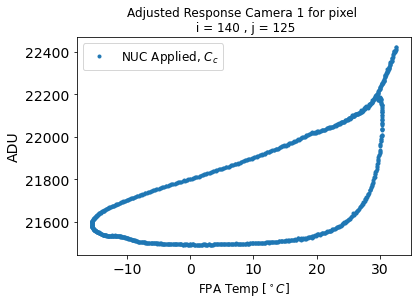

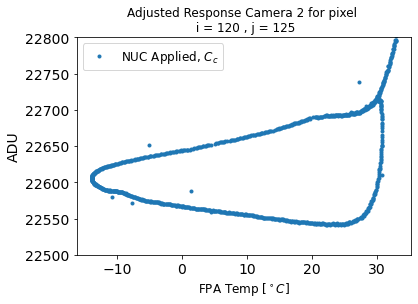

In [24]:
#plt.plot(fpatemps1,rs1,'.',label  ='No NUC, $R_c$')
plt.plot(fpatemps1,rcs1,'.',label = "NUC Applied, $C_c$")
plt.legend(fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('FPA Temp [$^\circ C$]',fontsize = 12)
plt.ylabel('ADU',fontsize = 14)
#plt.ylim(21000,23200)
plt.title('Adjusted Response Camera 1 for pixel \n i = '+str(i1)+' , j = '+str(j1))
plt.show()

#plt.plot(fpatemps2,rs2,'.',label  ='No NUC, $R_c$')
plt.plot(fpatemps2,rcs2,'.',label = "NUC Applied, $C_c$")
plt.legend(fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('FPA Temp [$^\circ C$]',fontsize = 12)
plt.ylabel('ADU',fontsize = 14)
plt.ylim(22500,22800)
plt.title('Adjusted Response Camera 2 for pixel \n i = '+str(i2)+' , j = '+str(j2))
plt.show()

In [225]:

fns = ['Center_0mm_neg0c.h5','Center_0mm_neg10c.h5','Center_0mm_neg35c.h5']

RS1 =[]; RCS1 =[]; RS2 =[]; RCS2 =[];

for g in range(len(fns)):
    cool_df = create_NUC_df('/Volumes/KESU/chamber_data/',fns[g])
    correct_temps(cool_df, "temps1")
    correct_temps(cool_df, "temps2")
    
    i1 = 140; j1 = 125;
    fpatemps1 = np.array(cool_df['temps1'])
    fpatemps2 = np.array(cool_df['temps2'])
    rs1 = np.zeros(len(cool_df))
    rcs1 = np.zeros(len(cool_df))
    for k in range(len(cool_df)):
        im  = np.array(cool_df['imgs1'])[k]
        r = im[i1,j1]
        rs1[k] = r
        rcor = rc(r,fpatemps1[k],m1[i1,j1],b1[i1,j1],T_ref1)
        rcs1[k]= rcor

    
    i2 = 120; j2 = 125;
    rs2 = np.zeros(len(cool_df))
    rcs2 = np.zeros(len(cool_df))
    for k in range(len(cool_df)):
        im  = np.array(cool_df['imgs2'])[k]
        r = im[i2,j2]
        rs2[k] = r
        rcor = rc(r,fpatemps2[k],m2[i2,j2],b2[i2,j2],T_ref2)
        rcs2[k]= rcor    
        
    RS1.append(rs1)  ; RCS1.append(rcs1) ;RS2.append(rs2)  ; RCS2.append(rcs2)  

<ipython-input-177-185cfc3be164>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key][i] = t2


[Text(0, 0.5, 'Camera 2')]

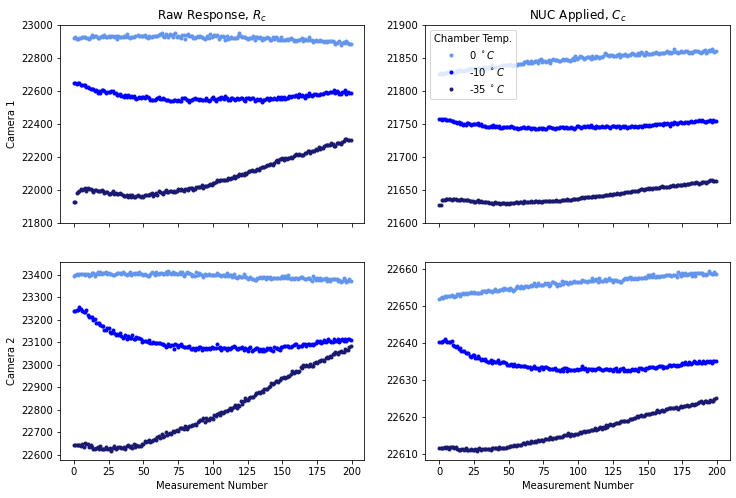

In [262]:
fig, axs = plt.subplots(2, 2,figsize=(12, 8), sharex=True,)
colors = ['cornflowerblue','b','midnightblue']
temps = ["0 $^\circ C$","-10 $^\circ C$","-35 $^\circ C$"]

for q in range(3):
    axs[0,0].plot(RS1[q],'.',c=colors[q])
    axs[0,0].set_title("Raw Response, $R_c$")
    axs[0,0].set_ylim(21800,23000)
    
    axs[0,1].plot(RCS1[q],'.',c=colors[q],label  =temps[q])
    axs[0,1].set_title("NUC Applied, $C_c$")
    axs[0,1].set_ylim(21600,21900)
    axs[0,1].legend(title ="Chamber Temp.")

for q in range(3):
    axs[1,0].plot(RS2[q],'.',c=colors[q])
    #axs[1,0].set_ylim(21000,22000)
    
    axs[1,1].plot(RCS2[q],'.',c=colors[q])

# set labels
plt.setp(axs[-1, :], xlabel='Measurement Number')
plt.setp(axs[0, 0], ylabel='Camera 1')
plt.setp(axs[1, 0], ylabel='Camera 2')


In [281]:
'''choose filepath to desired data'''
save_path = '/Volumes/KESU/calibration_files/'
name =  'NUC031621'
  
#create hdf5 file
hf = h5py.File(save_path + name + '.h5', 'w')
hf.create_dataset('/m1',  data=m1)
hf.create_dataset('/b1',  data=b1)
hf.create_dataset('/T_ref1',  data=T_ref1)
hf.create_dataset('/m2',  data=m2)
hf.create_dataset('/b2',  data=b2)
hf.create_dataset('/T_ref2',  data=T_ref2)
hf.close()